# Optimizing the server routine without communication

I am optimizing the server routine without communication.

The benchmarks are run on different number of cores. The limit of the cores is handled by docker. The number of workers is equal to the number of processors.

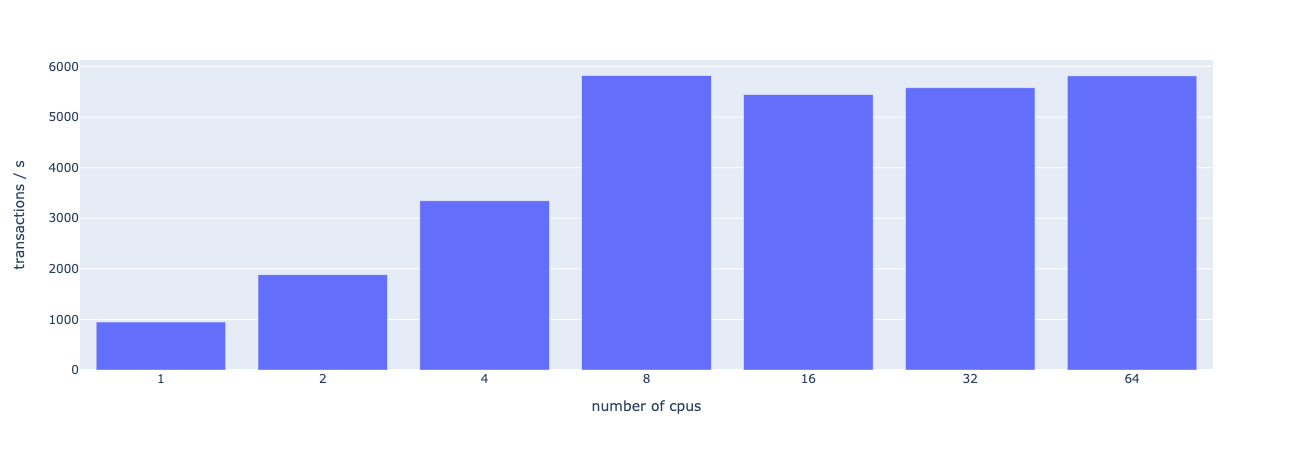

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

d1 = pd.read_csv("server-routine/data.csv")

fig = px.bar(x=d1["cpus"], y=1/(d1["nsop"]*10**-9))
fig.update_layout(xaxis_type='category')
fig.update_yaxes(title_text="transactions / s")
fig.update_xaxes(title_text="number of cpus")

fig.show()

That means that the server routine does not scale properly.

## Analysing bottleneck #1

Server: 64-core general purpose AWS linux server.

### Block profiling

Using 1 core: `1core-block.svg`

Using 64 cores: `64cores-block.svg`

### Analysis result

We can see that my **hash function** is very inefficient. In my hash function I first print the struct (to a string), then hash the string. There must be a more efficient way.

## Fixing the bottleneck

Now using `encoding/gob` which streams into `crypto/sha3` directly.

Before:

```go
func HashValueSprintf(value Value) []byte {
	d := sha3.New256()
	value.Signatures = nil                   	// zero out signatures before hash
	d.Write([]byte(fmt.Sprintf("%v", value)))	// this may be slow!
	return d.Sum(nil)
}
```

After:

```go
func HashValue(value Value) []byte {
	value.Signatures = nil                    	// zero out signatures before hash
	d := sha3.New256()
	enc := gob.NewEncoder(d)
	enc.Encode(value)
	return d.Sum(nil)
}
```

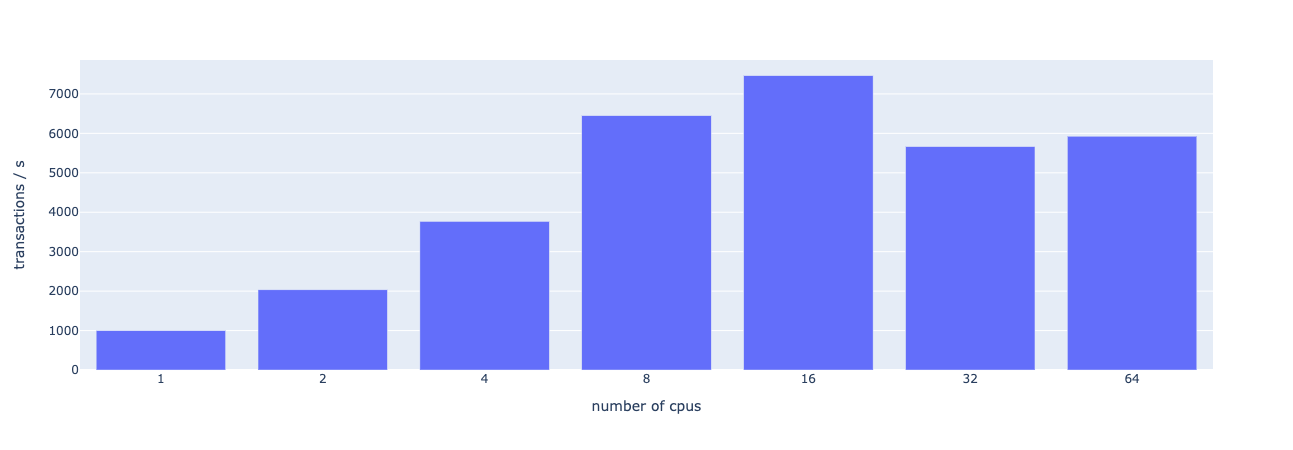

In [14]:
d1 = pd.read_csv("server-routine/data2.csv")

fig = px.bar(x=d1["cpus"], y=1/(d1["nsop"]*10**-9))
fig.update_layout(xaxis_type='category')
fig.update_yaxes(title_text="transactions / s")
fig.update_xaxes(title_text="number of cpus")

fig.show()

## Analysing bottleneck #2

### Block profiling

Using 1 core: `1core-block-2.svg`

Using 64 cores: `64cores-block-2.svg`

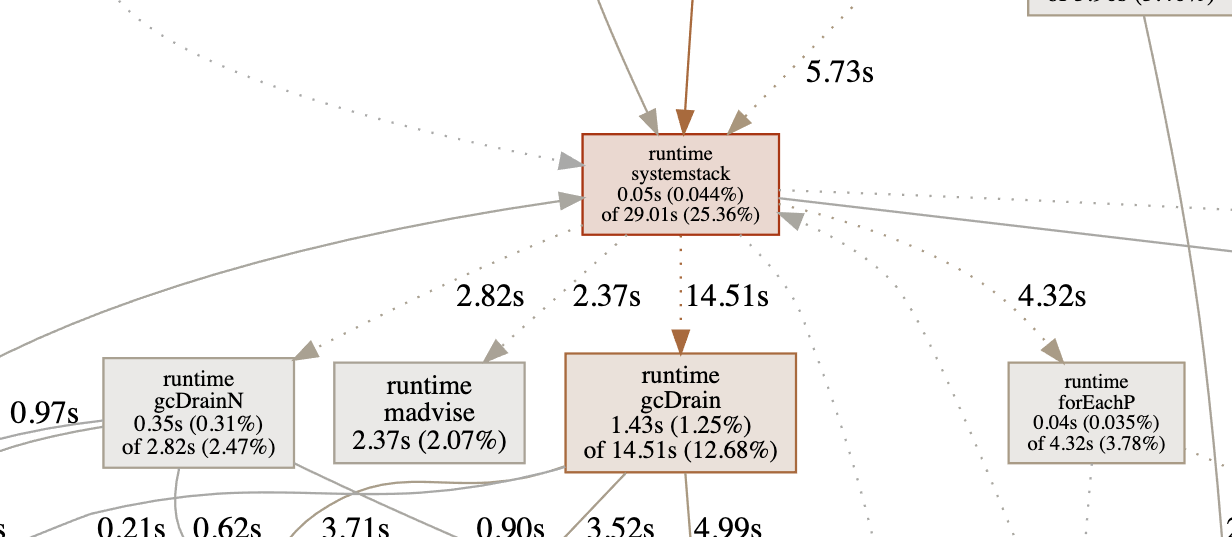

## Hints

The garbage collector seems to be the problem. Ideas: tune the gc --> GOGC, increase memory performance.

Profile when using 1 core, 1 second:

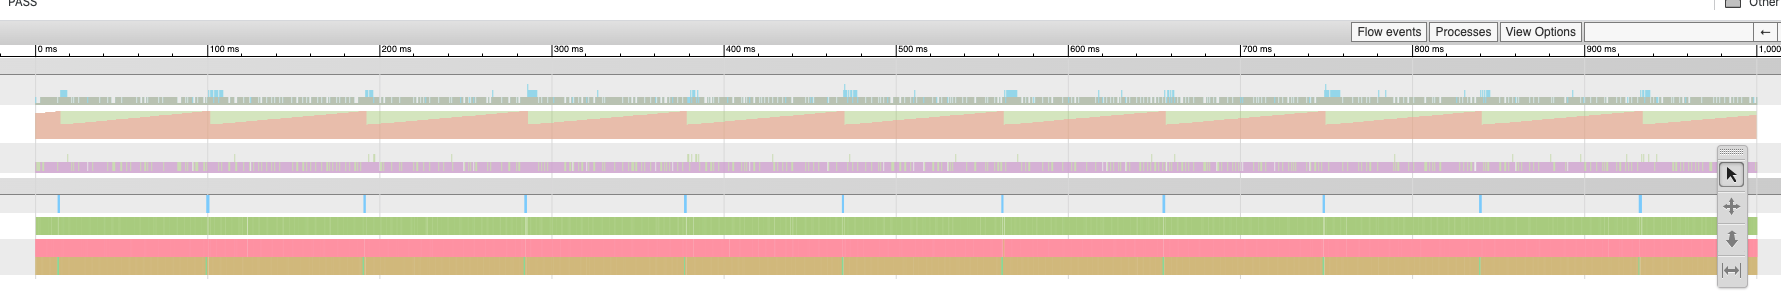

When using 64 cores, 1 second:

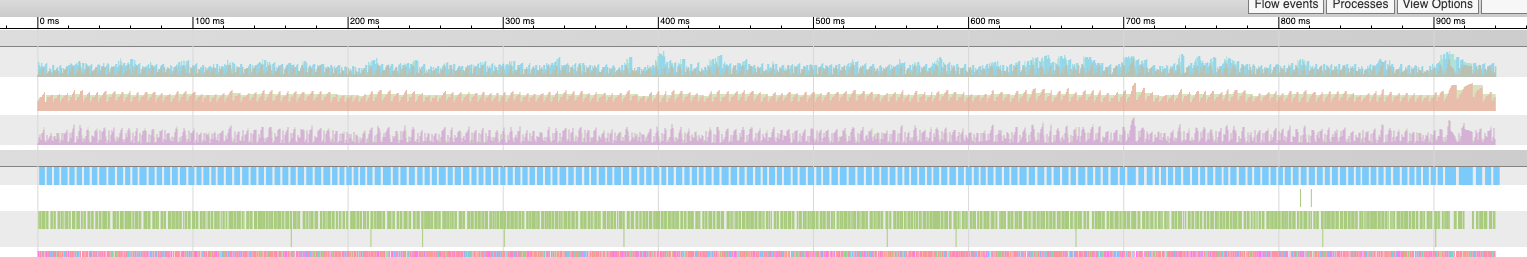

## Optimizing the Go GC

I want that the Go GC doesn't collect the garbage as often, since this often blocks the execution. For that, I set an option that the Go compiler only collects its garbage when the original size of the heap is 10x larger. Result:

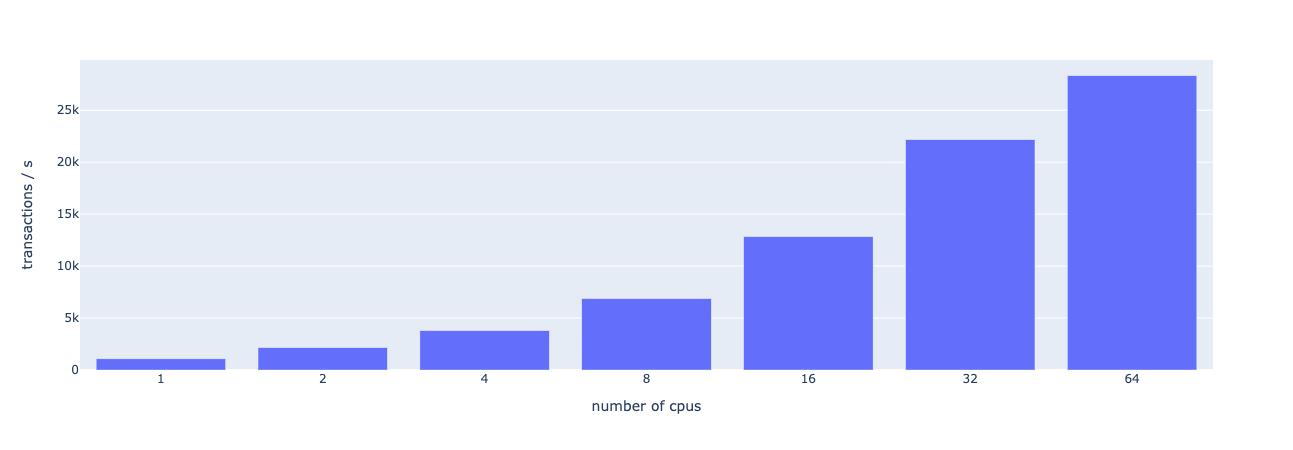

In [17]:
d = pd.read_csv("server-routine/data3.csv")

fig = px.bar(x=d["cpus"], y=1/(d["nsop"]*10**-9))
fig.update_layout(xaxis_type='category')
fig.update_yaxes(title_text="transactions / s")
fig.update_xaxes(title_text="number of cpus")

fig.show()

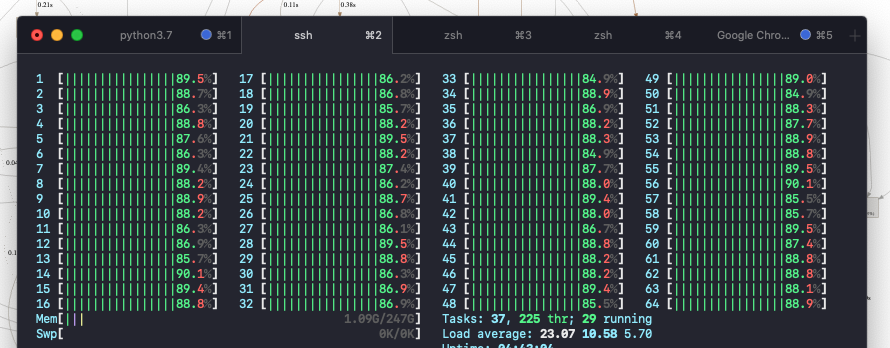

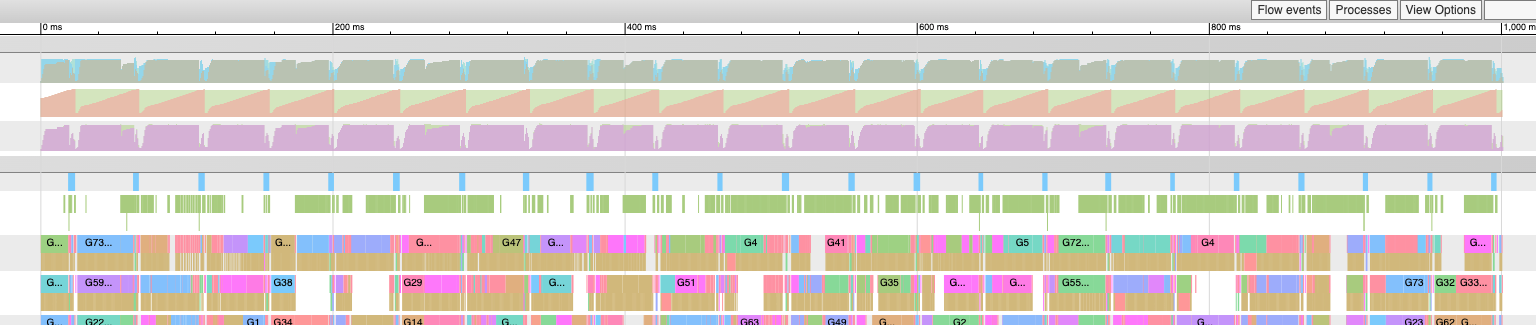

## Optimizing memory usage

There were pieces of code which looked like this:

```go
pubkey := UnmarshalPubkey(sig.Address)
R := new(big.Int).SetBytes(sig.R)
S := new(big.Int).SetBytes(sig.S)
valid := ecdsa.Verify(pubkey, hash, R, S)
```

This is one instance and there were many more. Basically there was a lot of copying big integer and bytes for transport. I optimized that so that this didn't happen anymore:

```go
pubkey := UnmarshalPubkey(sig.Address)
valid := ecdsa.Verify(pubkey, hash, sig.R, sig.S)
```

I changed the type of the signature to big integers.